# Bayesian Networks: The Sprinkler Model


In this tutorial, we'll explore how to build and perform inference in Bayesian networks using RxInfer. Bayesian networks are probabilistic graphical models that represent conditional dependencies between random variables through directed acyclic graphs. We'll use the `DiscreteTransition` node type to encode conditional probability tables (CPTs) that define how each variable depends on its parents in the network. Through a classic sprinkler example, we'll demonstrate how to construct these networks and perform probabilistic inference to answer queries about the model.


In [1]:
using RxInfer, Plots, GraphViz

This example implements a classic Bayesian network known as the sprinkler model. The model represents causal relationships between:

- Whether it is cloudy (clouded)
- Whether it is raining (rain) 
- Whether the sprinkler is on (sprinkler)
- Whether the grass is wet (wet_grass)
 
The relationships are:
- Cloudy weather influences both rain and sprinkler usage
- Both rain and sprinkler usage affect whether the grass is wet
 
We'll use this model to demonstrate inference under different scenarios and evidence.

The bayesian network for the sprinkler model is shown below:

![Sprinkler model diagram showing the relationships between clouded, rain, sprinkler and wet_grass nodes](sprinklermodel.jpg)



Let's translate this into an RxInfer model. We'll start by putting a `Categorial` prior on the clouded variable, and we'll use `DiscreteTransition` nodes to encode the CPTs for the rain and sprinkler variables, which depend on the clouded variable. Denote that we denote a binary probability distribution as a vector of two probabilities, where the first probability is the probability of the event not occurring and the second probability is the probability of the event occurring.

In [2]:
@model function sprinkler_model(wet_grass)
    clouded ~ Categorical([0.5, 0.5]) # Probability of cloudy being false or true
    rain ~ DiscreteTransition(clouded, [0.8 0.2; 0.2 0.8])
    sprinkler ~ DiscreteTransition(clouded, [0.5 0.9; 0.5 0.1])
    wet_grass ~ DiscreteTransition(sprinkler, [1.0 0.1; 0.0 0.9;;; 0.1 0.01; 0.9 0.99], rain)
end

Optionally, let's inspect the model structure that RxInfer creates using the GraphViz package:


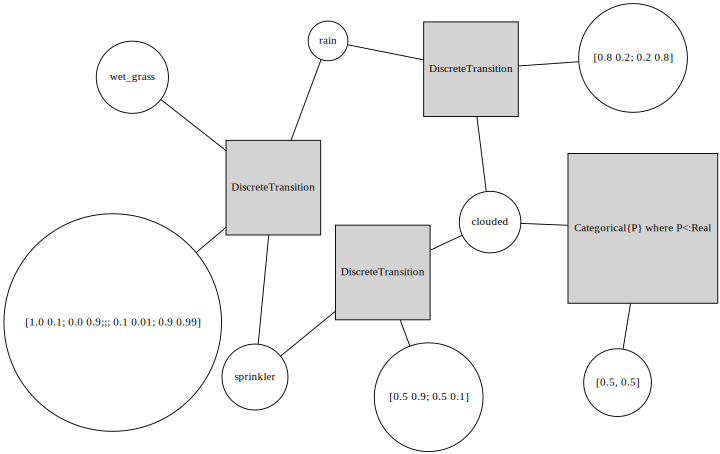

In [3]:
model_generator = sprinkler_model() | (wet_grass = [ 1.0, 0.0 ], )
model_to_plot   = RxInfer.getmodel(RxInfer.create_model(model_generator))
GraphViz.load(model_to_plot, strategy = :simple)

Because we have a loop in the resulting factor graph, we have to initialize messages to run the loopy belief propagation algorithm. We'll initialize the messages for the `sprinkler` variable to be uniform. Afterwards, we can run the inference with the `infer` function from `RxInfer`. Furthermore, we can specify the number of iterations to run the loopy belief propagation algorithm, and we can query the `free_energy` to monitor the convergence of the algorithm.

In [4]:
initialization = @initialization begin
    μ(sprinkler) = Categorical([0.5, 0.5])
end

data = (wet_grass = [1.0, 0.0],) # Grass is dry

result = infer(model=sprinkler_model(), data=data, iterations=10, initialization=initialization, free_energy=true)

Inference results:
  Posteriors       | available for (rain, sprinkler, clouded)
  Free Energy:     | Real[1.04157, 1.04157, 1.04157, 1.04157, 1.04157, 1.04157, 1.04157, 1.04157, 1.04157, 1.04157]


Let's plot the free energy to monitor the convergence of the loopy belief propagation algorithm:

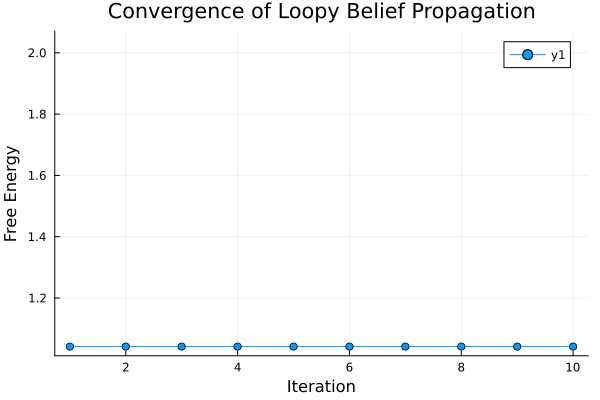

In [5]:
plot(result.free_energy, 
     xlabel="Iteration", 
     ylabel="Free Energy",
     title="Convergence of Loopy Belief Propagation",
     marker=:circle)

Great! It looks like the free energy is converging nicely. Now, let's inspect the posterior probabilities for the clouded, rain, and sprinkler variables:

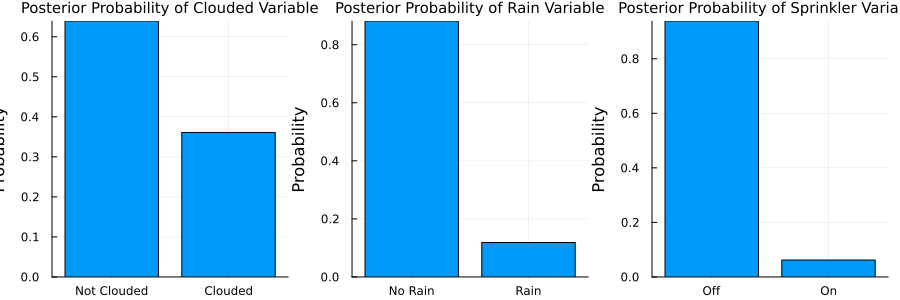

In [6]:
p1 = bar(last(result.posteriors[:clouded]).p,
    xticks=(1:2, ["Not Clouded", "Clouded"]),
    ylabel="Probability",
    title="Posterior Probability of Clouded Variable",
    titlefontsize=10,
    legend=false)

p2 = bar(last(result.posteriors[:rain]).p,
    xticks=(1:2, ["No Rain", "Rain"]),
    ylabel="Probability", 
    title="Posterior Probability of Rain Variable",
    titlefontsize=10,
    legend=false)

p3 = bar(last(result.posteriors[:sprinkler]).p,
    xticks=(1:2, ["Off", "On"]),
    ylabel="Probability",
    title="Posterior Probability of Sprinkler Variable", 
    titlefontsize=10,
    legend=false)

plot(p1, p2, p3, layout=(1,3), size=(900,300))


Looks like, when the grass is dry, it is less likely to be cloudy, less likely to rain and the sprinkler is probably off. Let's look at what happens when we observe wet grass:

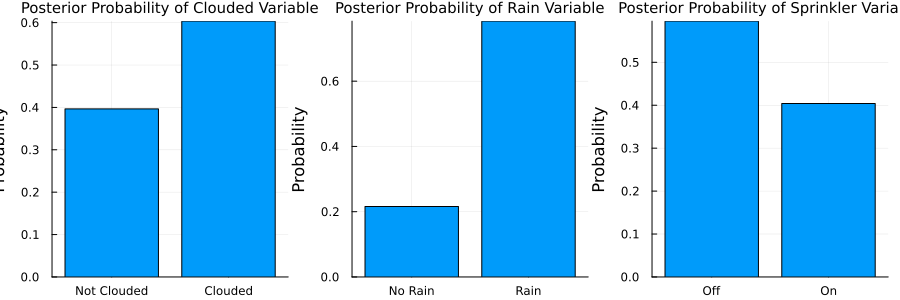

In [7]:
result = infer(model=sprinkler_model(), data=(wet_grass=[0.0, 1.0],), iterations=10, initialization=initialization)
p1 = bar(last(result.posteriors[:clouded]).p,
    xticks=(1:2, ["Not Clouded", "Clouded"]),
    ylabel="Probability",
    title="Posterior Probability of Clouded Variable",
    titlefontsize=10,
    legend=false)

p2 = bar(last(result.posteriors[:rain]).p,
    xticks=(1:2, ["No Rain", "Rain"]),
    ylabel="Probability", 
    title="Posterior Probability of Rain Variable",
    titlefontsize=10,
    legend=false)

p3 = bar(last(result.posteriors[:sprinkler]).p,
    xticks=(1:2, ["Off", "On"]),
    ylabel="Probability",
    title="Posterior Probability of Sprinkler Variable", 
    titlefontsize=10,
    legend=false)

plot(p1, p2, p3, layout=(1,3), size=(900,300))

Perfect! When the grass is wet, it is more likely to be cloudy, more likely to rain and the sprinkler is more likely to be on. However, this model only allows observations on the grass being wet, and not on the sprinkler being on or off. Let's extend the model to also observe the sprinkler and rain variables:

# Extending the model

We will now also accept observations on the sprinkler, rain  and clouded variables, which means that we will have to add the variables to the model signature and denote how this data is generated. We know that these datapoints are the same as the hidden variables they are conditioned on, so we can use a `DiscreteTransition` node to encode this identity relationship between the data and the hidden variables.

In [8]:
@model function sprinkler_model(wet_grass_data, sprinkler_data, rain_data, clouded_data)
    clouded ~ Categorical([0.5, 0.5]) # Probability of cloudy being false or true
    clouded_data ~ DiscreteTransition(clouded, diageye(2))  
    rain ~ DiscreteTransition(clouded, [0.8 0.2; 0.2 0.8])
    rain_data ~ DiscreteTransition(rain, diageye(2))
    sprinkler ~ DiscreteTransition(clouded, [0.5 0.9; 0.5 0.1])
    sprinkler_data ~ DiscreteTransition(sprinkler, diageye(2))
    wet_grass ~ DiscreteTransition(sprinkler, [1.0 0.1; 0.0 0.9;;; 0.1 0.01; 0.9 0.99], rain)
    wet_grass_data ~ DiscreteTransition(wet_grass, diageye(2))
end

Now, we can run the inference with the extended model, where we pass in the data for the observations we have, and pass `missing` for the observations we don't have. What happens, for example, if we observe the grass being wet and the sprinkler being on?

In [9]:
result = infer(model=sprinkler_model(), data=(wet_grass_data=[0.0, 1.0], sprinkler_data=[0.0, 1.0], rain_data=missing, clouded_data=missing), iterations=10, initialization=initialization)


Inference results:
  Posteriors       | available for (rain, sprinkler, wet_grass, clouded)
  Predictions      | available for (rain_data, clouded_data)


Perfect! When the grass is wet and the sprinkler is on, it is less likely to rain, and therefore less likely to be cloudy. What happens to the grass when we observe rain and the sprinkler is off?

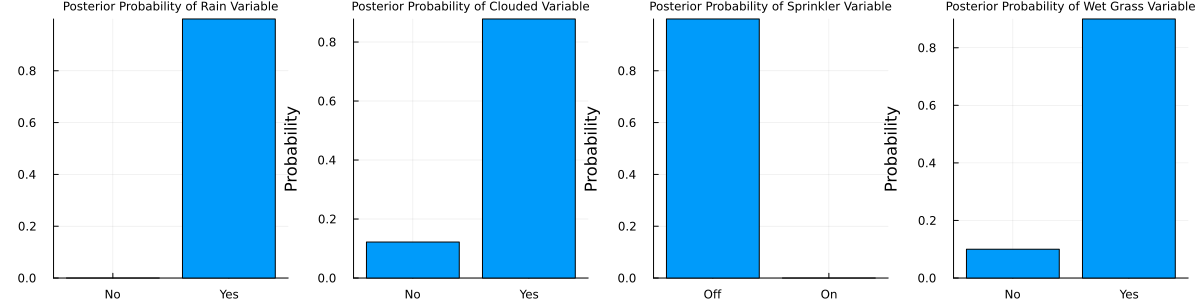

In [10]:
result = infer(model=sprinkler_model(), data=(wet_grass_data=missing, sprinkler_data=[1.0, 0.0], rain_data=[0.0, 1.0], clouded_data=missing), iterations=10, initialization=initialization)


p1 = bar(last(result.posteriors[:rain]).p,
    xticks=(1:2, ["No", "Yes"]),
    ylabel="Probability", 
    title="Posterior Probability of Rain Variable",
    titlefontsize=8,
    legend=false)

p2 = bar(last(result.posteriors[:clouded]).p,
    xticks=(1:2, ["No", "Yes"]),
    ylabel="Probability",
    title="Posterior Probability of Clouded Variable",
    titlefontsize=8,
    legend=false)

p3 = bar(last(result.posteriors[:sprinkler]).p,
    xticks=(1:2, ["Off", "On"]),
    ylabel="Probability",
    title="Posterior Probability of Sprinkler Variable", 
    titlefontsize=8,
    legend=false)

p4 = bar(last(result.posteriors[:wet_grass]).p,
    xticks=(1:2, ["No", "Yes"]),
    ylabel="Probability",
    title="Posterior Probability of Wet Grass Variable",
    titlefontsize=8,
    legend=false)

plot(p1, p2, p3, p4, layout=(1,4), size=(1200,300))



Finally, what happens if we observe the grass being wet and the sky being blue?

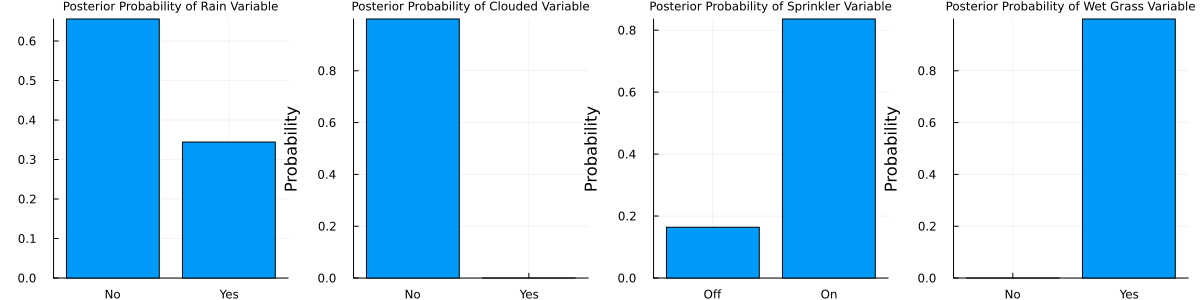

In [11]:
result = infer(model=sprinkler_model(), data=(wet_grass_data=[0.0, 1.0], sprinkler_data=missing, rain_data=missing, clouded_data=[1.0, 0.0]), iterations=10, initialization=initialization)


p1 = bar(last(result.posteriors[:rain]).p,
    xticks=(1:2, ["No", "Yes"]),
    ylabel="Probability", 
    title="Posterior Probability of Rain Variable",
    titlefontsize=8,
    legend=false)

p2 = bar(last(result.posteriors[:clouded]).p,
    xticks=(1:2, ["No", "Yes"]),
    ylabel="Probability",
    title="Posterior Probability of Clouded Variable",
    titlefontsize=8,
    legend=false)

p3 = bar(last(result.posteriors[:sprinkler]).p,
    xticks=(1:2, ["Off", "On"]),
    ylabel="Probability",
    title="Posterior Probability of Sprinkler Variable", 
    titlefontsize=8,
    legend=false)

p4 = bar(last(result.posteriors[:wet_grass]).p,
    xticks=(1:2, ["No", "Yes"]),
    ylabel="Probability",
    title="Posterior Probability of Wet Grass Variable",
    titlefontsize=8,
    legend=false)

plot(p1, p2, p3, p4, layout=(1,4), size=(1200,300))



# Learning the CPTs

We can also use `RxInfer` to learn the CPT's when we have data available, for this, let's generate some data


In [12]:
# Generate synthetic data from the true model
n_samples = 10000

# Initialize arrays to store the samples
clouded_samples = zeros(Int, n_samples)
rain_samples = zeros(Int, n_samples)
sprinkler_samples = zeros(Int, n_samples) 
wet_grass_samples = zeros(Int, n_samples)

# Sample from the model
for i in 1:n_samples
    # Sample clouded (prior)
    clouded_samples[i] = rand() < 0.5 ? 1 : 2
    
    # Sample rain (depends on clouded)
    rain_prob = clouded_samples[i] == 1 ? 0.2 : 0.8
    rain_samples[i] = rand() > rain_prob ? 1 : 2
    
    # Sample sprinkler (depends on clouded)
    sprinkler_prob = clouded_samples[i] == 1 ? 0.5 : 0.1
    sprinkler_samples[i] = rand() > sprinkler_prob ? 1 : 2
    
    # Sample wet grass (depends on rain and sprinkler)
    if rain_samples[i] == 2 && sprinkler_samples[i] == 2
        wet_prob = 0.99
    elseif rain_samples[i] == 2
        wet_prob = 0.9
    elseif sprinkler_samples[i] == 2
        wet_prob = 0.9
    else
        wet_prob = 0.0
    end
    wet_grass_samples[i] = rand() < wet_prob ? 2 : 1
end
# Convert to one-hot encoding
clouded_data = [[i == s ? 1.0 : 0.0 for i in 1:2] for s in clouded_samples]
rain_data = [[i == s ? 1.0 : 0.0 for i in 1:2] for s in rain_samples]
sprinkler_data = [[i == s ? 1.0 : 0.0 for i in 1:2] for s in sprinkler_samples]
wet_grass_data = [[i == s ? 1.0 : 0.0 for i in 1:2] for s in wet_grass_samples];

The model now becomes a little bit more complex, as we have to put a prior on the CPT's, and we have to materialze the model for every datapoint we have. Luckily, in `RxInfer`, we can make a submodel and reuse it for every datapoint. We can put a `DirichletCollection` prior on the CPT's, as it is the conjugate prior of the CPT's. Because we cannot do belief propagation with a `DirichletCollection` prior, we have to introduce variational constraints to introduce an Expectation Maximization-style schema. This can be done with the `@constraints` macro. Furthermore, we can use the `@initialization` macro to initialize the variational distributions and kickstart the inference procedure.

In [13]:
@model function sprinkler_model(clouded_data, rain_data, sprinkler_data, wet_grass_data, cpt_cloud_rain, cpt_cloud_sprinkler, cpt_sprinkler_rain_wet_grass)
    clouded ~ Categorical([0.5, 0.5]) # Probability of cloudy being false or true
    clouded_data ~ DiscreteTransition(clouded, diageye(2))
    rain ~ DiscreteTransition(clouded, cpt_cloud_rain)
    rain_data ~ DiscreteTransition(rain, diageye(2))
    sprinkler ~ DiscreteTransition(clouded, cpt_cloud_sprinkler)
    sprinkler_data ~ DiscreteTransition(sprinkler, diageye(2))
    wet_grass ~ DiscreteTransition(sprinkler, cpt_sprinkler_rain_wet_grass, rain)
    wet_grass_data ~ DiscreteTransition(wet_grass, diageye(2))
end

@model function learn_sprinkler_model(clouded_data, rain_data, sprinkler_data, wet_grass_data)
    cpt_cloud_rain ~ DirichletCollection(ones(2, 2))
    cpt_cloud_sprinkler ~ DirichletCollection(ones(2, 2))
    cpt_sprinkler_rain_wet_grass ~ DirichletCollection(ones(2, 2, 2))
    for i in 1:length(clouded_data)
        wet_grass_data[i] ~ sprinkler_model(clouded_data = clouded_data[i], rain_data = rain_data[i], sprinkler_data = sprinkler_data[i], cpt_cloud_rain = cpt_cloud_rain, cpt_cloud_sprinkler = cpt_cloud_sprinkler, cpt_sprinkler_rain_wet_grass = cpt_sprinkler_rain_wet_grass)
    end
end


In [14]:
initialization = @initialization begin
    q(cpt_cloud_rain) = DirichletCollection(ones(2, 2))
    q(cpt_cloud_sprinkler) = DirichletCollection(ones(2, 2))
    q(cpt_sprinkler_rain_wet_grass) = DirichletCollection(ones(2, 2, 2))
    for init in sprinkler_model
        μ(sprinkler) = Categorical([0.5, 0.5])
    end
end

constraints = @constraints begin
    for q in sprinkler_model
        q(cpt_cloud_rain, clouded, rain) = q(clouded,rain)q(cpt_cloud_rain)
        q(cpt_cloud_sprinkler, clouded, sprinkler) = q(clouded,sprinkler)q(cpt_cloud_sprinkler)
        q(cpt_sprinkler_rain_wet_grass, sprinkler, rain, wet_grass) = q(sprinkler,rain,wet_grass)q(cpt_sprinkler_rain_wet_grass)
    end
end

result = infer(model=learn_sprinkler_model(), 
            data=(clouded_data=clouded_data, rain_data=rain_data, sprinkler_data=sprinkler_data, wet_grass_data=wet_grass_data), 
            constraints=constraints, 
            initialization=initialization, 
            iterations=5, 
            showprogress=true,
            options=(limit_stack_depth=500,))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Inference results:
  Posteriors       | available for (cpt_cloud_sprinkler, cpt_cloud_rain, cpt_sprinkler_rain_wet_grass)


Wow! That was fast! Let's inspect the learned CPT's:

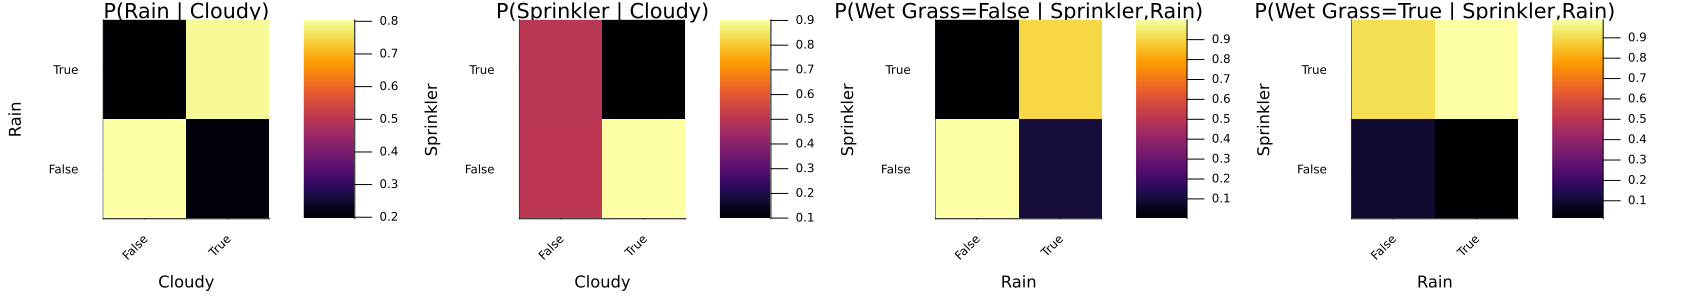

In [15]:
using Plots

# Plot CPT for cloud -> rain
cloud_rain = mean(last(result.posteriors[:cpt_cloud_rain]))
p1 = heatmap(cloud_rain, 
        title="P(Rain | Cloudy)", 
        xlabel="Cloudy", 
        ylabel="Rain",
        xticks=(1:2, ["False", "True"]),
        yticks=(1:2, ["False", "True"]),
        xrotation=45,
        left_margin=10Plots.mm,
        bottom_margin=10Plots.mm)

# Plot CPT for cloud -> sprinkler
cloud_sprinkler = mean(last(result.posteriors[:cpt_cloud_sprinkler]))
p2 = heatmap(cloud_sprinkler,
        title="P(Sprinkler | Cloudy)",
        xlabel="Cloudy",
        ylabel="Sprinkler", # Remove y-label since it's shown in p1
        xticks=(1:2, ["False", "True"]),
        yticks=(1:2, ["False", "True"]),
        xrotation=45,
        bottom_margin=10Plots.mm)

# Plot CPT for sprinkler,rain -> wet grass
sprinkler_rain_wet = mean(last(result.posteriors[:cpt_sprinkler_rain_wet_grass]))
p3 = heatmap(sprinkler_rain_wet[:,:,1],
        title="P(Wet Grass=False | Sprinkler,Rain)",
        xlabel="Rain",
        ylabel="Sprinkler", # Remove y-label since it's shown in p1
        xticks=(1:2, ["False", "True"]),
        yticks=(1:2, ["False", "True"]),
        xrotation=45,
        bottom_margin=10Plots.mm)
p4 = heatmap(sprinkler_rain_wet[:,:,2],
        title="P(Wet Grass=True | Sprinkler,Rain)", 
        xlabel="Rain",
        ylabel="Sprinkler", # Remove y-label since it's shown in p1
        xticks=(1:2, ["False", "True"]),
        yticks=(1:2, ["False", "True"]),
        xrotation=45,
        bottom_margin=15Plots.mm)

plot(p1, p2, p3, p4, layout=(1,4), size=(1700,305))

This concludes our tutorial on Bayesian networks. We have seen how to build and perform inference in Bayesian networks using RxInfer. We have also seen how to learn the CPT's when we have data available. As we have seen, RxInfer is able to learn posterior distributions even when some of the data is missing, what do you think will happen if we pass missing data to our model that learns the CPT's?